# Ekstrakcja cech z obrazów - Gabor, DWT, LBP, HoG, Histogram-y, Dominant Color
Dla skutecznej klasyfikacji zazwyczaj stosuje się ekstrakcję cech (ang. feature extraction) z obiektu (np. obrazu). Ekstrakcja cech polega na przetworzeniu obiektu do zestawu wielkości (cech), które reprezentują istotne informacje o obiekcie. Istnieje wiele sposobów ekstrakcji cech, natomiast dobór odpowiedniej metody jest zależny od rozpatrywanego zagadnienia, np. ekstrakcja cech z obrazów, sygnałów dźwiękowych, sygnałów medycznych.

Ekstrakcja cech to proces redukcji wymiarowości, w którym początkowy zestaw nieprzetworzonych danych jest redukowany do łatwiejszych do przetworzenia grup. Grupą taką może być wektor skalarów lub wektor macierzy.

Ekstrakcja cech może być także procesem wyodrebniania szczegółowych danych z nieprzetworzonych danych, które ułatwiają późniejszą analize tego zestawu danych. 

Ekstrakcja cech to nazwa dla metod, które wybierają i/lub łączą zmienne w cechy, skutecznie zmniejszając ilość danych, które muszą zostać przetworzone, a jednocześnie dokładnie i całkowicie opisują oryginalny zestaw danych.

W tym notatniku omówione zostaną popularne metody ekstrakcji cech takie jak:


1.   [Filtr Gabora](#gabor_filter)
2.   [DWT](#discrete_wavelet_transform) (Discrete Wavelet Transform) 
3.   [LBP](#lbp) (Local Binary Pattern) 
4.   [HoG](#hog) (Histogram of Oriented Gradients)
5.   [Histogram-y](#histograms) 
6.   [Dominant Color](#dominant_colors)



## Instalacja oraz import pakietów

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import cv2
import pywt
import h5py
import os

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import IPython.display as ipd

from skimage.feature import local_binary_pattern
from skimage.feature import hog

from sklearn.cluster import KMeans

from pywt._doc_utils import wavedec2_keys, draw_2d_wp_basis

<a name="gabor_filter"></a>
## Filtr Gabora

Idea filtrów Gabora opiera się na określeniu pewnych funkcji bazowych złożonych z funkcji gaussowskiej i sinusoidalnych. Umożliwia wykrywanie wzorców o różnych częstotliwościach i orientacjach. Wówczas, nakładając filtry Gabora na obraz dostajemy odpowiedź, która przekazywana jest do klasyfikatora. 
Ogólny wzór filtru Gabora ma następującą postać: 
$$ g(x,y;\lambda,\theta,\psi,\sigma,\gamma) = \exp\left(-\frac{x'^2+\gamma^2y'^2}{2\sigma^2}\right)\exp\left(i\left(2\pi\frac{x'}{\lambda}+\psi\right)\right) $$

gdzie paramtery odpowiadają odpowiednio:


*   λ - długość fali składowej sinusoidalnej,
*   θ - kąt pochylenia pasów Gabora,
*   ψ - przesunięcie fazowe funkcji sinusoidalnej,
*   σ - sigma/odchylenie standardowe obwiedni Gaussa,
*   γ - współczynnik proporcji przestrzennych i określa eliptyczność wsparcia funkcji Gabora.



### Filtr Gabora - wizualizacja parametrów

Wspomniane powyżej pięć parametrów kontroluje kształt i wielkość funkcji Gabora. Rolę każdego parametru omówiono szczegółowo poniżej. W celu zilustrowania wpływu parametrów, jako punkt wyjścia wybrano następujące wartości:

Sigma (**σ**) = 2π; Theta (**Ө**) = 0°; Lambda (**λ**) = 30°;  Gamma (**ɣ**) = 0.25;  Psi (Ψ) = 0°

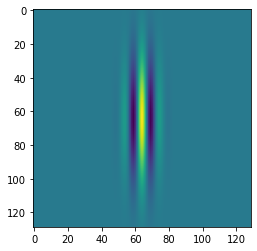

In [46]:
ksize = 128 
sigma = 2*np.pi # Duża wartość tego parametru może pomijać małe cechy,
theta = 0 # Wartość w radianach,
lambd = np.radians(30) # Wartość do funkcji jest przekazywana w radianach dlatego należy przeliczyć wartość 30 na radiany, 
gamma = 0.25 # Wartość 1 definiuje kulisty kształt filtru. Wartość bliska 0 ma wysoki poziom spłaszczenia filtru,
phi = 0  # Na samym początku warto ustawić te wartość na 0.

kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)

plt.imshow(kernel)

Poniżej znajduje się funkcja pomocnicza do wyświetlania obrazów w jednym rzędzie:

In [13]:
def display_images_in_row(imgs, title, figsize=(12, 12), cmap='gray'):
  fig = plt.figure(figsize=figsize)
  st = fig.suptitle(title, fontsize="x-large")

  idx = 1
  for img in imgs:
    ax = fig.add_subplot(len(imgs), len(imgs), idx)
    ax.imshow(img, cmap=cmap)
    idx += 1

  fig.tight_layout()
  st.set_y(0.95)
  fig.subplots_adjust(top=0.90)

**Sigma (σ):**

Szerokość pasma lub sigma kontroluje ogólny rozmiar obwiedni Gabora. W przypadku większej przepustowości obwiednia zwiększa się, pozwalając na więcej pasków, a przy małej przepustowości obwiednia zacieśnia się. Po zwiększeniu sigma do 2π i 3π zwiększa się liczba pasków w funkcji Gabora.

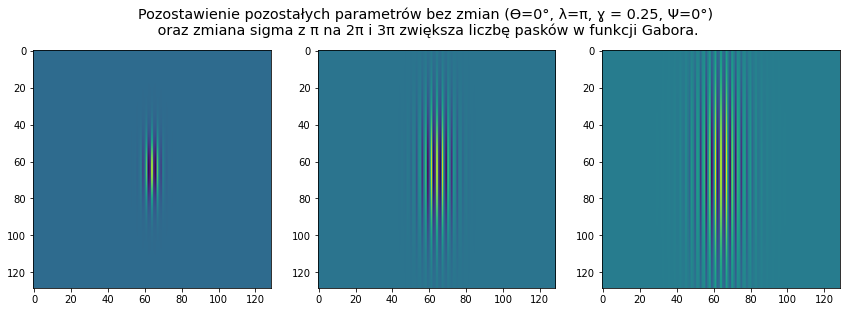

In [14]:
imgs = [
  cv2.getGaborKernel((ksize, ksize), np.pi, np.radians(0), np.pi, 0.25, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), 2*np.pi, np.radians(0), np.pi, 0.25, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), 3*np.pi, np.radians(0), np.pi, 0.25, phi, ktype=cv2.CV_32F),
]
title = "Pozostawienie pozostałych parametrów bez zmian (Ө=0°, λ=π, ɣ = 0.25, Ψ=0°)\n oraz zmiana sigma z π na 2π i 3π zwiększa liczbę pasków w funkcji Gabora."
display_images_in_row(imgs, title, cmap='viridis')

**Theta (Ө):**

Theta kontroluje obrót funkcji Gabora. Theta o wartość 0° odpowiada pionowemu położeniu funkcji Gabora. 

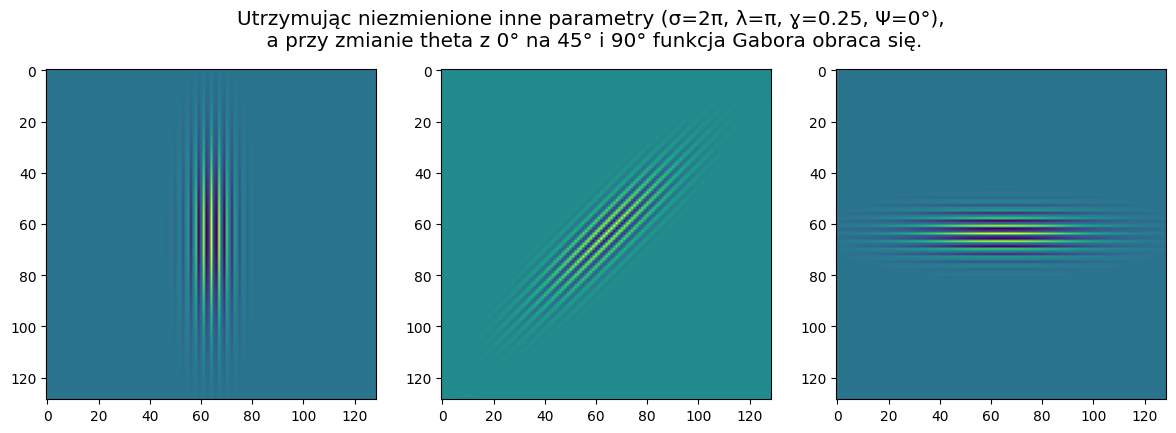

In [50]:
imgs = [
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(0), np.pi, gamma, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(45), np.pi, gamma, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(90), np.pi, gamma, phi, ktype=cv2.CV_32F)
]
title = "Utrzymując niezmienione inne parametry (σ=2π, λ=π, ɣ=0.25, Ψ=0°),\n a przy zmianie theta z 0° na 45° i 90° funkcja Gabora obraca się."
display_images_in_row(imgs, title, cmap='viridis')

**Lambda (λ):**

Długość fali reguluje szerokość pasków funkcji Gabora. Zwiększanie długości fali daje szersze paski, a zmniejszanie długości fali – cieńsze paski.

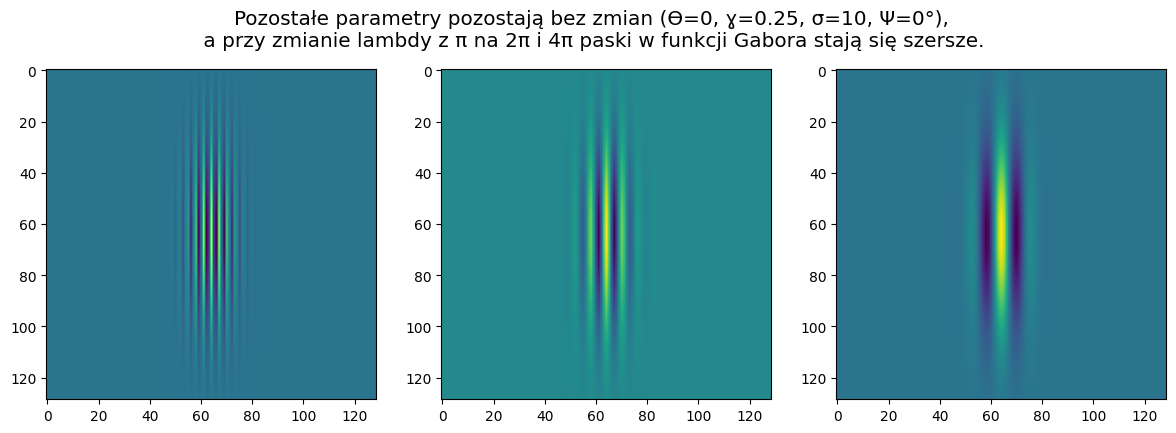

In [51]:
imgs = [
  cv2.getGaborKernel((ksize, ksize), sigma, theta, np.pi, gamma, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, theta, 2*np.pi, gamma, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, theta, 4*np.pi, gamma, phi, ktype=cv2.CV_32F)
]
title = "Pozostałe parametry pozostają bez zmian (Ө=0, ɣ=0.25, σ=10, Ψ=0°),\n a przy zmianie lambdy z π na 2π i 4π paski w funkcji Gabora stają się szersze."
display_images_in_row(imgs, title, cmap='viridis')

**Gamma (ɣ):**

Współczynnik proporcji lub gamma kontroluje wysokość funkcji Gabora. Dla bardzo wysokich proporcji wysokość staje się bardzo mała, a dla bardzo małej wartości gamma wysokość staje się duża. Przy zwiększeniu wartości gamma do 0,5 i 0,75, przy utrzymaniu innych parametrów bez zmian, wysokość funkcji Gabora zmniejsza się.

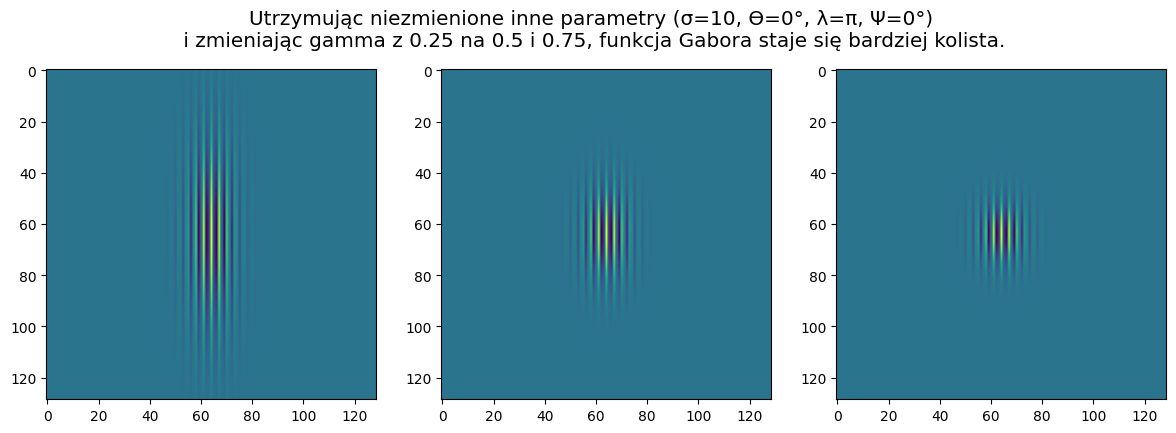

In [52]:
imgs = [
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(0), np.pi, 0.25, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(0), np.pi, 0.5, phi, ktype=cv2.CV_32F),
  cv2.getGaborKernel((ksize, ksize), sigma, np.radians(0), np.pi, 0.75, phi, ktype=cv2.CV_32F),
]
title = "Utrzymując niezmienione inne parametry (σ=10, Ө=0°, λ=π, Ψ=0°)\n i zmieniając gamma z 0.25 na 0.5 i 0.75, funkcja Gabora staje się bardziej kolista."
display_images_in_row(imgs, title, cmap='viridis')

In [15]:
def demoGabor(theta, sigma):
    kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, np.pi, 0.25, phi, ktype=cv2.CV_32F)
    plt.figure();
    plt.axis('off')
    plt.imshow(kernel)

widgets.interactive(demoGabor, theta=(0, np.pi, np.pi/8), sigma=(1, 5, 0.1))

interactive(children=(FloatSlider(value=1.5707963267948966, description='theta', max=3.141592653589793, step=0…

### Przykład z zebrą

W tym przykładzie pobierzemy obraz zebry i za pomocą 16 różnych filtrów Gabora postaramy się wydobyć z obrazu kontury zebry. 

Poniżej znajduje się kod który wygeneruje nam zestaw 16 filtrów, które zostaną nałożone na zdjęcie.

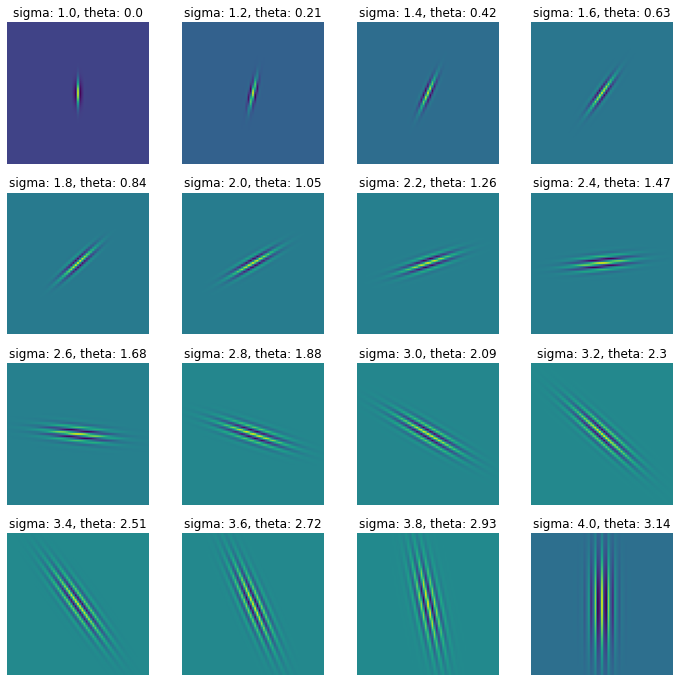

In [47]:
theta = np.linspace(0, np.pi, 16) # zakres parametru theta
sigma = np.linspace(1, 4, 16) # zakres parametru sigma
params = zip(theta, sigma)
filters_bank = []
gabor_params = []

for (theta, sigma) in params:
    gabor_param = {'sigma':sigma, 'theta':theta, 'sz':(64, 64)}
    gabor_kernel = cv2.getGaborKernel(gabor_param['sz'], sigma, theta, np.pi, 0.25, phi, ktype=cv2.CV_32F)
    filters_bank.append(gabor_kernel)
    gabor_params.append(gabor_param)

plt.figure(figsize=(12, 12))
n = len(filters_bank)
for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title("sigma: " + str(round(gabor_params[i]['sigma'], 2)) + 
              ", theta: " + str(round(gabor_params[i]['theta'], 2)))
    plt.axis('off')
    plt.imshow(filters_bank[i])


In [55]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/9/96/Common_zebra_1.jpg/1280px-Common_zebra_1.jpg -O zebra.jpg

'wget' is not recognized as an internal or external command,
operable program or batch file.


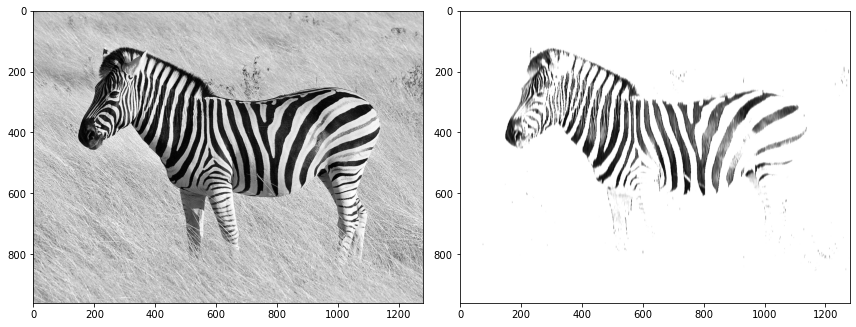

In [48]:
def process(img, filters):
        accum = np.zeros_like(img)
        for kern in filters:
            fimg = cv2.filter2D(img, cv2.CV_8UC3, kern)
            np.maximum(accum, fimg, accum)
            return accum

img = cv2.imread('./zebra.jpg', 0)
res=process(img, filters_bank)
display_images_in_row([cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(res, cv2.COLOR_BGR2RGB)], "")

### Ćwiczenie 1.1
Zastosuj filtry Gabora do obrazu zebry.

1. Dostosuj częstotliwość i orientację filtrów Gabora, aby znaleźć poziome i pionowe paski. Wykreśl obraz wyjściowy.

2. Czy możesz wskazać/znaleźć filtry Gabora, które wyodrębniają informacje o nogach?

Parametr sigma kontroluje częstotliwość fali sinusoidalnej i wpływa na rozmiar filtra Gabora. Zmieniając wartości sigma w liniowo przestrzeni (sigma = np.linspace(1, 4, 8)), zmieniamy częstotliwość fali sinusoidalnej i rozmiar filtra Gabora. Wartości większe niż 1 oznaczają większe rozmiary filtrów i niższe częstotliwości, a wartości mniejsze niż 1 oznaczają mniejsze rozmiary filtrów i wyższe częstotliwości.

Parametr theta określa kierunek fali sinusoidalnej w filtrze Gabora i może być ustawiony w zakresie od 0 do pi. W powyższym kodzie, wartości parametru theta są równomiernie rozmieszczone w zakresie od 0 do pi (theta = np.linspace(0, np.pi , 8)), co oznacza, że mamy 8 filtrów Gabora o różnych kierunkach fali sinusoidalnej.

Możemy modyfikować wartości sigma i theta w celu uzyskania filtrów Gabora o różnych rozmiarach i częstotliwościach oraz kierunkach fali sinusoidalnej, co pozwala na wykrycie różnych cech obrazów, takich jak krawędzie, tekstury, kontury i wiele innych.

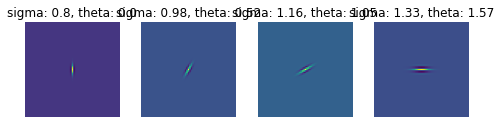

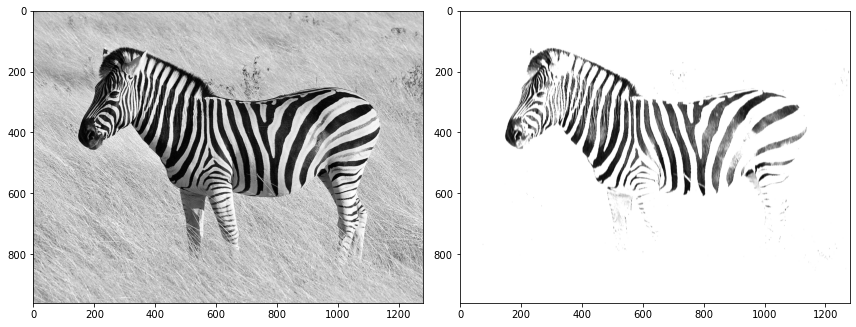

In [52]:
#Miejsce na rozwiązanie zadania
theta = np.linspace(0, np.pi/2 , 4) # zakres parametru theta
sigma = np.linspace(0.8, 4/3, 4) # zakres parametru sigma
params = zip(theta, sigma)
filters_bank = []
gabor_params = []

for (theta, sigma) in params:
    gabor_param = {'sigma':sigma, 'theta':theta, 'sz':(64, 64)}
    gabor_kernel = cv2.getGaborKernel(gabor_param['sz'], sigma, theta, np.pi, 0.35, phi, ktype=cv2.CV_32F)
    filters_bank.append(gabor_kernel)
    gabor_params.append(gabor_param)

plt.figure(figsize=(8, 8))
n = len(filters_bank)
for i in range(n):
    plt.subplot(4, 4, i+1)
    plt.title("sigma: " + str(round(gabor_params[i]['sigma'], 2)) + 
              ", theta: " + str(round(gabor_params[i]['theta'], 2)))
    plt.axis('off')
    plt.imshow(filters_bank[i])

res=process(img, filters_bank)
display_images_in_row([cv2.cvtColor(img, cv2.COLOR_BGR2RGB), cv2.cvtColor(res, cv2.COLOR_BGR2RGB)], "")

<a name="discrete_wavelet_transform"></a>
## DWT (Discrete Wavelet Transform)

W polskiej literaturze termin ten tłumaczony jest jako [transformacja falkowa](https://pl.wikipedia.org/wiki/Transformacja_falkowa). Transformacja falkowa jest podobna do transformaty Fouriera (lub znacznie bardziej do okienkowej transformaty Fouriera) lecz z zupełnie inną funkcją merytoryczną. 

Główną wadą transformacji Fouriera jest to, że przechwytuje informacje o częstotliwościach globalnych, co oznacza częstotliwości, które utrzymują się w całym sygnale. Ten rodzaj rozkładu sygnału może nie sprawdzać się we wszystkich zastosowaniach, na przykład w elektrokardiografii (EKG), gdzie sygnały mają krótkie odstępy charakterystycznych oscylacji. Alternatywnym podejściem jest właśnie przekształcenie falkowe, które rozkłada funkcję na zbiór falek.

Wavelet(falka) to oscylacja podobna do fali, która jest zlokalizowana w czasie, przykład podano poniżej. Falki mają dwie podstawowe właściwości: skalę i położenie. Skala (lub dylatacja) określa, jak „rozciągnięta” lub „zgnieciona” jest falka. Ta właściwość jest związana z częstotliwością zdefiniowaną dla fal. Lokalizacja określa, gdzie falka znajduje się w czasie (lub przestrzeni).

Kilka kluczowych zalet transformacji falkowej to:

*   Transformacja falkowa może jednocześnie wyodrębniać lokalne informacje spektralne i czasowe,
*   Różnorodność falek do wyboru.

Pierwszej kluczowa przewaga została już kilka razy wspomniana w tym rozdziale. Jest to prawdopodobnie największy powód, dla którego warto skorzystać z przekształcenia falkowego. Może to być lepsze niż użycie czegoś takiego jak krótkotrwała transformata Fouriera, która wymaga podzielenia sygnału na fragmenty i wykonania transformacji Fouriera na każdym fragmencie.

Druga z powyższych zalet brzmi bardziej jak szczegół techniczny. Ostatecznie najważniejsze jest to, że jeśli wiadomo, jaki charakterystyczny kształt próbujemy wydobyć z badanego sygnału, istnieje wiele różnych fal do wyboru. Dzięki temu można wybrać te najbardziej odpowiednią do naszego przykładu. 

Poniżej znajduje się kilka przykładów różnych falek z pakietu SciKit.


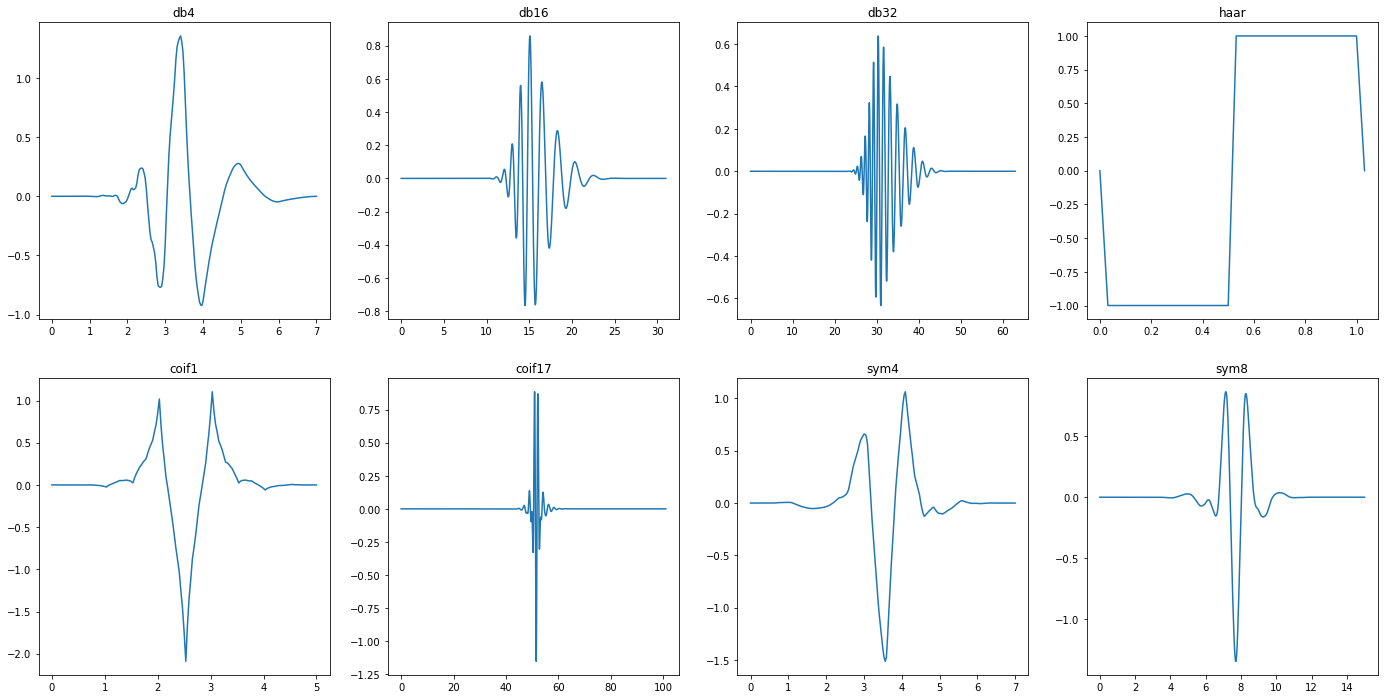

In [56]:
plt.figure(figsize=(24, 12))
wavelets = ['db4', 'db16', 'db32', 'haar', 'coif1', 'coif17','sym4', 'sym8', 'sym16']
for i in range(8):
    x = np.linspace(-3, 3, 300)
    wavelet = pywt.Wavelet(wavelets[i])
    [phi, psi, x] = wavelet.wavefun(level=5)
    plt.subplot(2, 4, i+1)
    plt.title(wavelets[i])
    plt.plot(x, psi[::-1])
plt.show()

### Wizualizacja parametru skali oraz położenia

Weźmy dla przykładu funkcję Guassa:

$f(x) = \exp(-\frac{(x - \mu)^2}{2\sigma^2})$

Parametr sigma w powyższym wyrażeniu określa skalę falki. Jeśli zmniejszymy jego wartość, falka będzie wyglądać na bardziej zgniecioną. To z kolei może przechwytywać informacje o wysokiej częstotliwości. I odwrotnie, zwiększenie wartości sigma rozciągnie falkę i przechwyci informacje o niskiej częstotliwości.

In [34]:
x = np.linspace(-3, 3, 300)

def gaussian(sigma, mean, x):
  y = np.exp(-((x - mean)**2/(2.0*sigma**2))) # Gaussian distribution
  return y

def draw_gaussian(sigma, mean):
    y = gaussian(sigma, mean, x)
    plt.plot(x, y, label = '$\sigma$ = 0.2')
    plt.show()

widgets.interactive(draw_gaussian, sigma=(0.1, 1, 0.1), mean=fixed(0))
# draw_gaussian(0.5,0)

interactive(children=(FloatSlider(value=0.5, description='sigma', max=1.0, min=0.1), Output()), _dom_classes=(…

Parametr mean określa położenie falki. Zmniejszenie mean przesunie falkę w lewo. Zwiększenie mean przesunie go w prawo. Lokalizacja jest ważna, ponieważ w przeciwieństwie do fal, falki są niezerowe tylko w krótkim odstępie czasu. Co więcej, analizując sygnał, interesują nas nie tylko jego drgania, ale także miejsce, w którym te drgania mają miejsce.

In [36]:
widgets.interactive(draw_gaussian, sigma=fixed(0.5), mean=(-1, 1, 0.25))

interactive(children=(FloatSlider(value=0.0, description='mean', max=1.0, min=-1.0, step=0.25), Output()), _do…

Poniżej zbiór wszystkich falek dostępych w pakiecie:

In [37]:
for family in pywt.families():
  print("%s family: " % family + ', '.join(pywt.wavelist(family)))

haar family: haar
db family: db1, db2, db3, db4, db5, db6, db7, db8, db9, db10, db11, db12, db13, db14, db15, db16, db17, db18, db19, db20, db21, db22, db23, db24, db25, db26, db27, db28, db29, db30, db31, db32, db33, db34, db35, db36, db37, db38
sym family: sym2, sym3, sym4, sym5, sym6, sym7, sym8, sym9, sym10, sym11, sym12, sym13, sym14, sym15, sym16, sym17, sym18, sym19, sym20
coif family: coif1, coif2, coif3, coif4, coif5, coif6, coif7, coif8, coif9, coif10, coif11, coif12, coif13, coif14, coif15, coif16, coif17
bior family: bior1.1, bior1.3, bior1.5, bior2.2, bior2.4, bior2.6, bior2.8, bior3.1, bior3.3, bior3.5, bior3.7, bior3.9, bior4.4, bior5.5, bior6.8
rbio family: rbio1.1, rbio1.3, rbio1.5, rbio2.2, rbio2.4, rbio2.6, rbio2.8, rbio3.1, rbio3.3, rbio3.5, rbio3.7, rbio3.9, rbio4.4, rbio5.5, rbio6.8
dmey family: dmey
gaus family: gaus1, gaus2, gaus3, gaus4, gaus5, gaus6, gaus7, gaus8
mexh family: mexh
morl family: morl
cgau family: cgau1, cgau2, cgau3, cgau4, cgau5, cgau6, cgau7, 

### Przykład dekompozycji za pomocą transformacji falkowej

Dekompozycja to proces podziału czegoś na części składowe. W kontekście przetwarzania sygnałów i obrazów, dekompozycja polega na podziale sygnału lub obrazu na elementy, które są łatwiejsze do analizy i przetwarzania.
W tym przykładzie używam typu dyskretnej transformacji falkowej, aby pomóc sobie w ekstrakcji cech ze standardowego zdjęcia Lena.

Zaczniemy od pobrania danych i ich wizualizacji:

In [38]:
!wget https://upload.wikimedia.org/wikipedia/en/7/7d/Lenna_%28test_image%29.png

'wget' is not recognized as an internal or external command,
operable program or batch file.


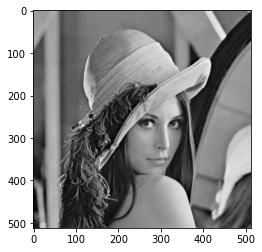

In [63]:
img2 = cv2.imread('./Lenna_(test_image).png', 0)
plt.figure(figsize=(25, 4))
plt.imshow(img, cmap='gray')
plt.show()


Do wykonania dekompozycji użyjemy gotowego pakiety Python pywt. W poniższym przykładzie wykorzystana jest falka **sym4**.
Transformacja falkowa jest wykorzystywana do dekompozycji sygnałów, w tym również do dekompozycji obrazów. Podczas dekompozycji, oryginalny sygnał jest dzielony na składowe o różnych częstotliwościach, co pozwala na reprezentację sygnału w dziedzinie częstotliwościowej.

Transformacja falkowa wykonuje dekompozycję sygnału na składowe przy użyciu zestawu funkcji zwanych "falkami". Zestaw ten jest konstruowany w taki sposób, aby fale o różnych częstotliwościach i rozmiarach reprezentowane były przez różne falki. Dzięki temu, dekompozycja falkowa pozwala na uzyskanie wielu poziomów szczegółowości sygnału.

W dekompozycji obrazów, transformacja falkowa jest stosowana dla każdej z trzech składowych koloru RGB oddzielnie, co pozwala na uzyskanie rozkładu obrazu na składowe poziomów szczegółowości. W ten sposób można uzyskać różne warianty obrazu, które opisują szczegółowe elementy tekstury, jak i ogólny kształt i układ obiektów na obrazie.

In [64]:
def plot_image_decomp(data, w, title, lvl):
    shape = data.shape
    max_lev = lvl       
    label_levels = 3 

    fig, axes = plt.subplots(2, lvl + 1, figsize=[14, 8])
    for level in range(0, max_lev + 1):
        if level == 0:
            axes[0, 0].set_axis_off()
            axes[1, 0].imshow(data, cmap='gray')
            axes[1, 0].set_title('Image res: ' + str(shape))
            axes[1, 0].set_axis_off()
            continue

        draw_2d_wp_basis(shape, wavedec2_keys(level), ax=axes[0, level],
                        label_levels=label_levels)
        axes[0, level].set_title('{} level\ndecomposition'.format(level))

        c = pywt.wavedec2(data, w, mode='periodization', level=level)
        # normalize each coefficient array independently for better visibility
        c[0] /= np.abs(c[0]).max()
        for detail_level in range(level):
            c[detail_level + 1] = [d/np.abs(d).max() for d in c[detail_level + 1]]
        # show the normalized coefficients
        arr, slices = pywt.coeffs_to_array(c)
        axes[1, level].imshow(arr, cmap=plt.cm.gray)
        axes[1, level].set_title('Coefficients\n({} level, res {})'.format(level, c[0].shape))
        axes[1, level].set_axis_off()

    plt.tight_layout()
    plt.show()


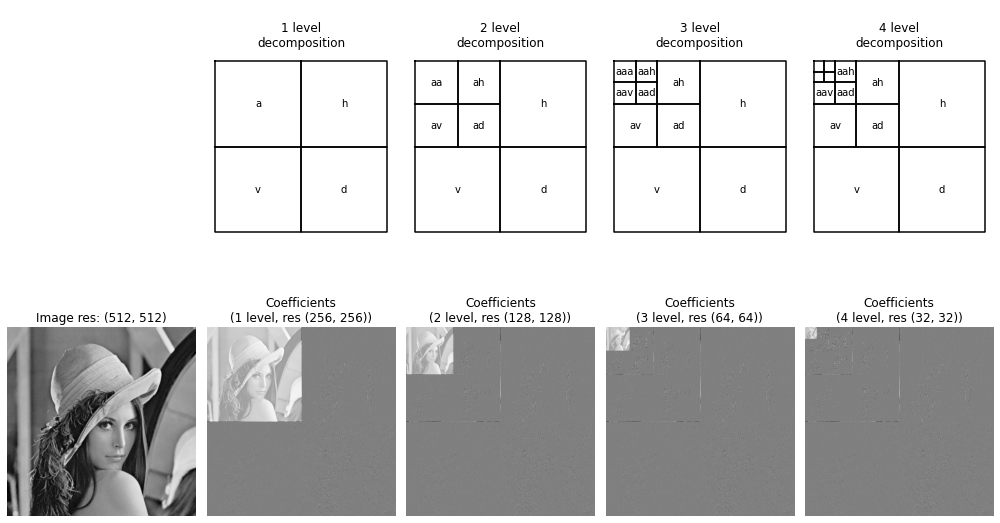

In [66]:
plot_image_decomp(img2, 'sym4', "Przykład dekompozycji za pomocą metody DWT obrazu Lena", lvl=4)

Wraz ze wzrostem poziomu dekompozycji widzimy coraz mniejszą rozdzielczość obrazu wyjściowego. W przypadku dekompozycji 3 stopnia jest to rozdzielczość 64x64 [px]. 

### Ćwiczenie 2.1

Za pomocą metody falkowej utworzyć wektor cech dla obrazów tekstur pochodzących ze zbioru Describable Textures Dataset (DTD): [link](https://www.robots.ox.ac.uk/~vgg/data/dtd/). 

Zadania:
1. Utworzyć wektory cech dla obrazków tekstur z rozszerzeniem ./texutures/typ.jpg,
2. Utworzyć wektory cech z dominującymi kolorami  dla obrazków tesktur z rozszerzeniem ./texutures/typ_valid.jpg,
3. Za pomocą  funkcji PSNR obliczyć podobieństwo pomiędzy tymi samymi grupami tekstur ex. bubbly.jpg -> bubbly_valid.jpg,
4. Za pomocą funkcji PSNR obliczyć odległość pomiędzy różynymi grupami tekstur ex. bubbly.jpg -> cracked.jpg,

Pytania:
1. Pomiędzy którymi obrazami w tej samej grupie odległości są największe?
2. Pomiędzy którymi grupami odlegość jest najmniejsza?

Działanie programu:
1. Tworzy wektory cech dla obrazów tekstur z rozszerzeniem ./textures/typ.jpg za pomocą falkowej metody dekompozycji.
2. Tworzy wektory cech z dominującymi kolorami dla obrazków tekstur z rozszerzeniem ./textures/typ_valid.jpg za pomocą falkowej metody dekompozycji.
3. Oblicza podobieństwo pomiędzy tymi samymi grupami tekstur za pomocą funkcji PSNR.
4. Oblicza odległość pomiędzy różnymi grupami tekstur za pomocą funkcji PSNR.
5. Wypisuje wyniki w konsoli.

In [67]:
!gdown https://drive.google.com/uc?id=19haLqueiJJPtuRrSQgsWRr9Zfs7in3kz
!unzip textures.zip

'gdown' is not recognized as an internal or external command,
operable program or batch file.
'unzip' is not recognized as an internal or external command,
operable program or batch file.


In [68]:
#Miejsce na rozwiązanie zadania
data_path = './textures/'

data = {}
labels = []

data_valid = {}

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if "_valid" in img: continue
  print('Create feature vector for file: ' + img)
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  c = pywt.wavedec2(img_data, 'sym4', mode='periodization', level=5)
  label = os.path.basename(img.replace('.jpg', ''))
  labels.append(label)
  data[label] = c[0]
  

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if not "_valid" in img: continue
  print('Create feature vector for validation file: ' + img)
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  c = pywt.wavedec2(img_data, 'sym4', mode='periodization', level=5)
  label = os.path.basename(img.replace('_valid.jpg', ''))
  data_valid[label] = c[0]

for label in labels:
  distance = cv2.PSNR(data[label], data_valid[label])
  print('Distance in group : ' + label + ' => ' + str(distance))

  other_groups = [x for x in labels if x != label]
  for group in other_groups:
    distance = cv2.PSNR(data[label], data[group])
    print('Distance beetween group : ' + label + ' vs ' + group + ' => ' + str(distance))

Create feature vector for file: bubbly.jpg
Create feature vector for file: bumpy.jpg
Create feature vector for file: cracked.jpg
Create feature vector for file: grooved.jpg
Create feature vector for file: honeycombed.jpg
Create feature vector for validation file: bubbly_valid.jpg
Create feature vector for validation file: bumpy_valid.jpg
Create feature vector for validation file: cracked_valid.jpg
Create feature vector for validation file: grooved_valid.jpg
Create feature vector for validation file: honeycombed_valid.jpg
Distance in group : bubbly => -17.063904577253982
Distance beetween group : bubbly vs bumpy => -21.579519231801342
Distance beetween group : bubbly vs cracked => -16.24415296781218
Distance beetween group : bubbly vs grooved => -12.239847930646526
Distance beetween group : bubbly vs honeycombed => -22.1694258724957
Distance in group : bumpy => -11.793091148124848
Distance beetween group : bumpy vs bubbly => -21.579519231801342
Distance beetween group : bumpy vs cracked

# Odpowiedzi na pytania
Odległość między dwoma grupami tekstur (mierzona przy użyciu funkcji PSNR) informuje nas o tym, jak podobne lub różne są te grupy tekstur w kontekście dominujących kolorów w obrazach tekstur. Im mniejsza jest odległość między grupami, tym bardziej podobne są do siebie w kontekście dominujących kolorów. Z drugiej strony, im większa jest odległość między grupami, tym bardziej różnią się od siebie w kontekście dominujących kolorów.

Pomiędzy którymi obrazami w tej samej grupie odległości są największe?
* Największa odległość między obrazami w tej samej grupie występuje w grupie "bubbly" i wynosi -17.06.

Pomiędzy którymi grupami odlegość jest najmniejsza?
- Najmniejsza odległość między grupami występuje między grupami "cracked" i "grooved" i wynosi -10.27.

<a name="lbp"></a>
## LBP (Local Binary Pattern)

Local Binary Patterns (LBP) to metoda deskryptora cech obrazów, która służy do wykrywania i opisu lokalnych wzorców w obrazie. Polega na przetwarzaniu pikseli w wybranym oknie przez porównywanie ich wartości z wartością piksela centralnego w tym oknie.

**Jak działa ten algorytm?**

Jak sama nazwa wskazuje, lokalny wzorzec binarny (w skrócie LBP) jest cechą lokalnej reprezentacji obrazu. Składa się z wartości względnych, porównując każdy piksel z sąsiednimi pikselami.
LBP działa następująco:
1. Określamy rozmiar okna, w którym będziemy analizować piksele.
2. Dla każdego piksela wewnątrz okna, porównujemy jego wartość z wartością piksela centralnego.
3. Jeśli wartość piksela jest większa lub równa wartości piksela centralnego, to przypisujemy mu wartość 1, w przeciwnym razie przypisujemy mu wartość 0.
4. Wynikowe wartości pikseli w oknie tworzą ciąg binarny, który jest zapisywany jako liczba dziesiętna.
5. Tworzony jest histogram dla całego obrazu, który reprezentuje wystąpienia różnych wartości ciągów binarnych.
6. Histogram ten jest następnie wykorzystywany jako deskryptor cech obrazu.

LBP jest stosowany w wielu zastosowaniach, w tym w rozpoznawaniu twarzy, detekcji obiektów oraz analizie tekstur. Metoda ta jest stosunkowo prosta i szybka obliczeniowo, co czyni ją atrakcyjną w praktycznych zastosowaniach.

Główną ideą LBP jest opisanie sąsiedztwa elementów obrazu za pomocą kodów binarnych. Ta metoda jest zwykle używana do badania ich lokalnych właściwości i identyfikacji cech poszczególnych części obrazu.

Algorytm ten jest kombinacją metod statystycznych i strukturalnych. Po raz pierwszy zaproponowali go T. Ojala, M. Pietikanen, T. Mehpaa z Uniwersytetu Oulu w Finlandii w 1994 roku. Jest uważana za metodę prostą i efektywną czasową, wykazującą doskonałe wyniki w wielu badaniach.

**Główne cechy LBP to:**


1.   niski koszt obliczeń,
2.   Odporność na wahania wartości skali szarości obrazu.

Od czasu pierwszej propozycji w 1994 roku wprowadzono wiele ulepszeń tego algorytmu. Zwłaszcza w systemach uczenia głębokiego jest on szeroko stosowany do rozpoznawania twarzy, segmentacji tekstur i innych aplikacji do analizy obrazu.

LBP wykrywa mikrostruktury, takie jak krawędzie, linie, plamy, płaskie obszary, które można oszacować za pomocą histogramu.

**Algorytm:**

1- Należy przekonwertować obraz na przestrzeń w skali szarości,

2- Podziel badane okno na komórki (np. 3x3 pikseli dla każdego piksela),

3- Dla każdego środkowego piksela w komórce porównaj piksel z każdym z jego 8 sąsiadów. Podążaj za pikselami wzdłuż okręgu, tj. zgodnie z ruchem wskazówek zegara lub przeciwnie do ruchu wskazówek zegara.

4- Ustaw na 1, jeśli wartość sąsiedniego piksela jest większa lub równa wartości środkowego piksela, 0 w przeciwnym razie.

5- Teraz oblicz wartość LBP: kolejno w kierunku przeciwnym do ruchu wskazówek zegara, zapisz liczbę binarną składającą się z cyfr sąsiadujących ze środkowym pikselem. Ta liczba binarna (lub jej dziesiętny odpowiednik) nazywana jest kodem **LBP-central pixel**, a ponadto jest wykorzystywana jako charakterystyczna wybrana lokalna tekstura.


$$ LBP(gp_{x}, gp_{y}) = \sum_{p=0}^{P-1}S(g_{p} - g_{c}) ⋅ 2^p $$

$g_{c}$- wartość intensywności centralnego piksela

$g_{p}$- intensywność sąsiedniego piksela o indeksie p

funkcję S można wyrazić jako:

\begin{align}
S(x) = \left\{
\begin{array}{cl}
1 & jeśli & x \ge 0 \\
0 & jeśli & x < 0.
\end{array}
\right.
\end{align}

### LBP - przykład
Za pomocą algorytmu LBP utworzymy wektory cech dla obrazów tekstur pochodzących ze zbioru Describable Textures Dataset (DTD): [link](https://www.robots.ox.ac.uk/~vgg/data/dtd/). Jest to ten sam zbiór, którego używaliśmy w poprzednim rozdziale.

In [74]:
data_path = './textures/'

data = []
labels = []

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if "_valid" in img: continue 
  # Read the image
  img = cv2.imread(data_path + "/" + img, 0)
  img = cv2.resize(img, (256, 256), interpolation = cv2.INTER_AREA)
  data.append(img)

Wizualizacja tekstur w skali szarości

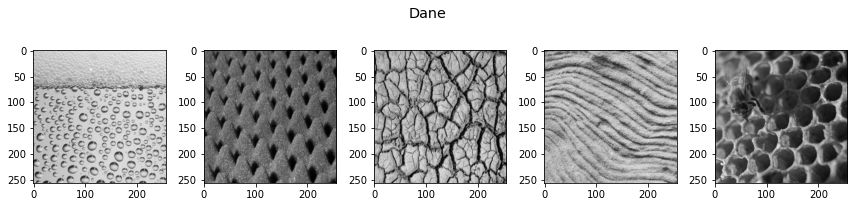

In [75]:
display_images_in_row([cv2.cvtColor(img, cv2.COLOR_BGR2RGB) for img in data], "Dane")

Utworzenie LBP dla każdego z obrazów 

In [76]:
# Ustawienia dla algorytmu LBP
METHOD = 'uniform' # Metoda określenia wzoru. Dostępne jeszcze: default, ror, uniform, nri_uniform, var
radius = 3 # Promień w którym zbierane będą punkty
n_points = 8 * radius # Parametr określający liczbę sąsiadujących kołowo symetrycznych punktów zadanych.

lbp_patterns = []

for img in data:
  lbp = local_binary_pattern(img, n_points, radius, METHOD)
  lbp_patterns.append(lbp)

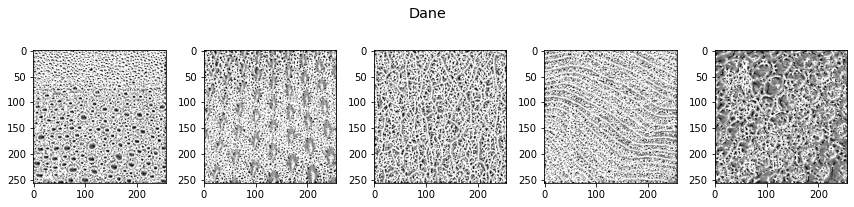

In [77]:
display_images_in_row(lbp_patterns, "Dane")

Utworzenie histogramów dla każdej z tekstur. W tym przypadku dane z histogramów będą naszym wektorem cech opisującym daną teksturę. 

In [78]:
histograms = []

for lbp in lbp_patterns:
  n_bins = int(lbp.max() + 1)
  hist, _ = np.histogram(lbp, density=True, bins=n_bins, range=(0, n_bins))
  histograms.append(hist)

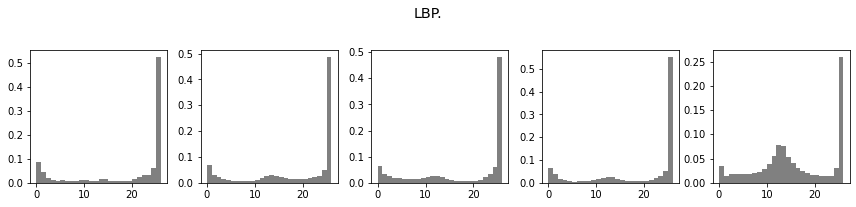

In [79]:
fig = plt.figure(figsize=(12, 12))
st = fig.suptitle("LBP.", fontsize="x-large")

idx = 1
for lbp in lbp_patterns:
  ax = fig.add_subplot(len(lbp_patterns), len(lbp_patterns), idx)
  n_bins = int(lbp.max() + 1)
  ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')
  idx += 1

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.90)

In [80]:
def kullback_leibler_divergence(p, q):
    return np.sum(np.where(p != 0, p * np.log(p / q), 0))

### Ćwiczenie 3.1
1. Utworzyć wektory cech dla obrazków tekstur z rozszerzeniem ./texutures/typ.jpg,
2. Utworzyć wektory cech z dominującymi kolorami  dla obrazków tesktur z rozszerzeniem ./texutures/typ_valid.jpg,
3. Za pomocą powyższej funkcji *kullback_leibler_divergence* obliczyć odległość pomiędzy tymi samymi grupami tekstur ex. bubbly.jpg -> bubbly_valid.jpg,
4. Za pomocą funkcji *kullback_leibler_divergence* obliczyć odległość pomiędzy różynymi grupami tekstur ex. bubbly.jpg -> cracked.jpg,
5. Wyświetlić porównanie histogramów, 

**Pytania:**
1. Pomiędzy którymi wektorami cech odległości są największe? 
2. Pomiędzy którymi grupami odlegość jest najmniejsza?
3. Opisz etapy tworzenia deskryptora LBP.


Create feature vector for file: bubbly.jpg
Create feature vector for file: bumpy.jpg
Create feature vector for file: cracked.jpg
Create feature vector for file: grooved.jpg
Create feature vector for file: honeycombed.jpg
Create feature vector for validation file: bubbly_valid.jpg
Create feature vector for validation file: bumpy_valid.jpg
Create feature vector for validation file: cracked_valid.jpg
Create feature vector for validation file: grooved_valid.jpg
Create feature vector for validation file: honeycombed_valid.jpg
Distance in group : bubbly => 0.31060914096424297
Distance beetween group : bubbly vs bumpy => 0.055681753664588274
Distance beetween group : bubbly vs cracked => 0.05286111567211961
Distance beetween group : bubbly vs grooved => 0.039920229213846
Distance beetween group : bubbly vs honeycombed => 0.42331189688589327
Distance in group : bumpy => 0.03560033741541258
Distance beetween group : bumpy vs bubbly => 0.07332053769463454
Distance beetween group : bumpy vs crack

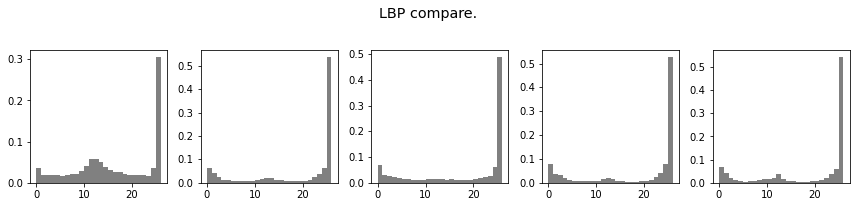

In [81]:
#Miejsce na rozwiązanie zadania
data_path = './textures/'

data = {}
lbps = {}
labels = []

data_valid = {}
lbps_valid = {}

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if "_valid" in img: continue
  print('Create feature vector for file: ' + img)
  label = os.path.basename(img.replace('.jpg', ''))
  labels.append(label)
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  result = local_binary_pattern(img_data, n_points, radius, METHOD)
  lbps[label] = result
  n_bins = int(result.max() + 1)
  hist, _ = np.histogram(result, density=True, bins=n_bins, range=(0, n_bins))
  data[label] = hist

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if not "_valid" in img: continue
  print('Create feature vector for validation file: ' + img)
  label = os.path.basename(img.replace('_valid.jpg', ''))
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  result = local_binary_pattern(img_data, n_points, radius, METHOD)
  lbps_valid[label] = result
  n_bins = int(result.max() + 1)
  hist, _ = np.histogram(result, density=True, bins=n_bins, range=(0, n_bins))
  data_valid[label] = hist

for label in labels:
  distance = kullback_leibler_divergence(data[label], data_valid[label])
  print('Distance in group : ' + label + ' => ' + str(distance))

  other_groups = [x for x in labels if x != label]
  for group in other_groups:
    distance = kullback_leibler_divergence(data[label], data[group])
    print('Distance beetween group : ' + label + ' vs ' + group + ' => ' + str(distance))

fig = plt.figure(figsize=(12, 12))
st = fig.suptitle("LBP compare.", fontsize="x-large")

idx = 1
for label in labels:
  lbp = lbps_valid[label]
  ax = fig.add_subplot(len(data), len(data), idx)
  n_bins = int(lbp.max() + 1)
  ax.hist(lbp.ravel(), density=True, bins=n_bins, range=(0, n_bins), facecolor='0.5')
  idx += 1

fig.tight_layout()
st.set_y(0.95)
fig.subplots_adjust(top=0.90)

Ten program wykonuje analizę porównawczą lokalnych wzorców binarnych (LBP) dla zbioru tekstur. Przeprowadzana jest ekstrakcja cech dla każdej tekstury przy pomocy metody LBP i następnie tworzony jest histogram częstości występowania poszczególnych wartości cech. Dla każdej tekstury tworzony jest też obiekt LBP, który będzie wykorzystany w walidacji. Następnie wyliczana jest odległość między histogramem cech walidacyjnej tekstury a każdą teksturą treningową w grupie oraz między histogramem cech dwóch różnych grup tekstur. Do wyliczenia odległości między histogramami cech jest wykorzystywana dywergencja Kullbacka-Leiblera. Ostatecznie program rysuje histogramy cech walidacyjnych tekstur dla porównania z histogramami cech tekstur treningowych.

Odległości między różnymi grupami służą do oceny podobieństwa obrazów z różnych kategorii. Dzięki tym odległościom możemy porównać, jak bardzo obrazy różnych kategorii różnią się od siebie i które z kategorii są sobie najbardziej podobne. Na przykład, jeśli wyniki pokazują, że odległość między obrazami honeycombed.jpg i bubbly.jpg jest najmniejsza, to znaczy, że te dwa obrazy są sobie najbardziej podobne. Z drugiej strony, jeśli wyniki pokazują, że odległość między obrazami honeycombed.jpg i cracked.jpg jest największa, to oznacza, że te dwa obrazy są sobie najbardziej odmienne.


# Odpowiedzi na pytania
1. Na podstawie wyników można stwierdzić, że największe odległości między wektorami cech występują między "honeycombed.jpg" a "bubbly.jpg".
2. Z wyników wynika, że najmniejsza odległość występuje w grupie "cracked", a konkretnie wynosi ona 0.024626356592965793. A między grupami "bumpy" i "cracked" jest najmniejsza odległość,i wynosi ona 0.024626356592965793.
3. Deskryptor LBP (ang. Local Binary Pattern) jest jednym z popularnych deskryptorów cech obrazów używanych do rozpoznawania obiektów na obrazach. Etapy tworzenia deskryptora LBP to:
    * Konwersja obrazu na odcienie szarości.
    * Podział obrazu na sąsiednie piksele (np. 3x3).
    * Porównanie wartości jasności pikseli z wartością jasności piksela centralnego. Jeśli wartość piksela jest większa lub równa niż wartość piksela centralnego, otrzymujemy 1, w przeciwnym wypadku otrzymujemy 0. W ten sposób otrzymujemy ciąg 0 i 1 dla każdego piksela z sąsiedztwa.
    * Konwertowanie ciągu 0 i 1 na liczbę dziesiętną, co daje nam tzw. wzorzec LBP.
    * Obliczanie histogramu z wzorców LBP na całym obrazie lub na wybranych regionach. Histogramy LBP są zwykle używane jako deskryptory cech do klasyfikacji obrazów.

<a name="hog"></a>
## HoG (Histogram of Oriented Gradients)

Metoda HoG polega na wykryciu krawędzi i gradientów w obrazie, a następnie obliczeniu histogramu orientacji gradientów w lokalnych regionach obrazu.
Histogramy  zorientowanych  gradientów  HOG  (ang. Histograms   of   Oriented Gradients)   to deskryptory obrazu, które opisują kształt i pomagają w znalezieniu  w  obrazie  konkretnego  obiektu. Idea  ich  działania  opiera  się  na  zliczaniu  występowania  gradientów  występujących  w  tej  samej orientacji przestrzennej (pod określonym kątem), w pewnym ściśle określonym fragmencie obrazu. Gradienty te są liczone w równomiernie rozmieszczonych fragmentach obrazu, w przeciwieństwie do innych deskryptorów, takich jak np. SIFT (ang. Scale-InvariantFeatureTransform). Aby poprawić skuteczność wykrywania obiektów stosuje się lokalną normalizację kontrastu w nakładających się na siebie regionach. Deskryptory  HOG  są  uzyskiwane  poprzez  podzielenie  obrazu  na  małe  fragmenty  (komórki), a następnie  dla  każdej  komórki  obliczany  jest  histogram  występowania  orientacji  krawędzi. Połączenie tych histogramów, obliczonych dla wszystkich komórek jest deskryptorem obrazu HOG



### HOG - przykład
Do tego przykładu wykorzystamy gotową funkcję z pakietu SciKit, która wygeneruje nam gotowe deskryptory oraz obrazy z algorytmu HOG. 


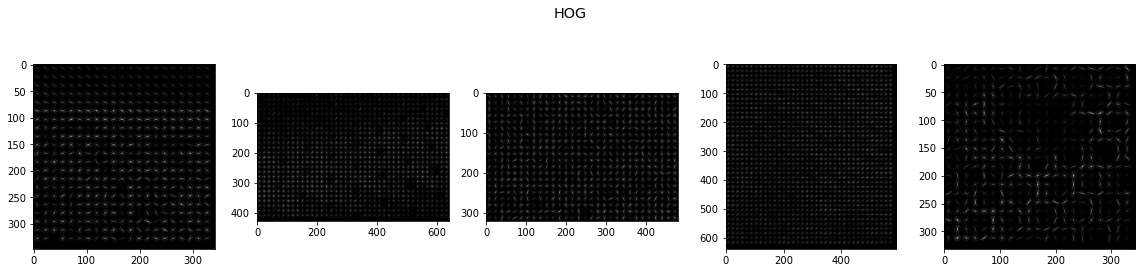

In [82]:
data_path = './textures/'
data = []

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if "_valid" in img: continue
  img_data = cv2.imread(data_path + "/" + img, 0)
  data.append(img_data)

features = []
hog_images = []

for img in data:
  # orinetnations - Liczba określająca ile wartości może przyjmować lokalny pojemnik w bloku orientacyjnym.
  # pixels_per_cell - Rozmiar (w pikselach) komórki w którym dokonywana jest analiza.
  # cells_per_block - Liczba komórek w każdym z bloków.
  # visualize - flaga określająca czy funkcja ma zwaracać obraz wizualizujący.
  fd, hog_image = hog(img, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
  features.append(fd)
  hog_images.append(hog_image)

display_images_in_row(hog_images, "HOG", figsize=(16, 16))

### Ćwiczenie 4.1
1. Utworzyć wektory cech dla obrazków tekstur z rozszerzeniem ./texutures/typ.jpg, dla dwóch wartości bloków (16, 32)
2. Utworzyć wektory cech z dominującymi kolorami  dla obrazków tesktur z rozszerzeniem ./texutures/typ_valid.jpg, dla dwóch wartości bloków (16, 32)
3. Za pomocą powyższej funkcji *kullback_leibler_divergence* obliczyć odległość pomiędzy tymi samymi grupami tekstur ex. bubbly.jpg -> bubbly_valid.jpg,

**Pytania:**
1. Czy wprowadzenie większego bloku wpłyneło na odległość pomiędzy tymi samymi parami? 
2. Jaka jest rola bloku w deskryptorze HoG ?
3.  Opisz etapy tworzenia deskryptora HoG.

In [92]:
#Miejsce na rozwiązanie zadania
data_path = './textures/'

fd_16 = {}
fd_32 = {}
labels = []

fd_16_valid = {}
fd_32_valid = {}

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if "_valid" in img: continue
  print('Create feature vector for file: ' + img)
  label = os.path.basename(img.replace('.jpg', ''))
  labels.append(label)
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  fd, hog_image = hog(img_data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
  fd_16[label] = fd
  fd, hog_image = hog(img_data, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(1, 1), visualize=True)
  fd_32[label] = fd

for img in os.listdir(data_path):
  if ".jpg" not in img: continue
  if not "_valid" in img: continue
  print('Create feature vector for validation file: ' + img)
  label = os.path.basename(img.replace('_valid.jpg', ''))
  # Read the image
  img_data = cv2.imread(data_path + "/" + img, 0)
  img_data = cv2.resize(img_data, (256, 256), interpolation = cv2.INTER_AREA)
  fd, hog_image = hog(img_data, orientations=8, pixels_per_cell=(16, 16), cells_per_block=(1, 1), visualize=True)
  fd_16_valid[label] = fd
  fd, hog_image = hog(img_data, orientations=8, pixels_per_cell=(32, 32), cells_per_block=(1, 1), visualize=True)
  fd_32_valid[label] = fd

print("Results for 16px cell")
for label in labels:
  distance = kullback_leibler_divergence(fd_16[label], fd_16_valid[label])
  print('Distance in group : ' + label + ' => ' + str(distance))

print("Results for 32px cell")
for label in labels:
  distance = kullback_leibler_divergence(fd_32[label], fd_32_valid[label])
  print('Distance in group : ' + label + ' => ' + str(distance))

Create feature vector for file: bubbly.jpg
Create feature vector for file: bumpy.jpg
Create feature vector for file: cracked.jpg
Create feature vector for file: grooved.jpg
Create feature vector for file: honeycombed.jpg
Create feature vector for validation file: bubbly_valid.jpg
Create feature vector for validation file: bumpy_valid.jpg
Create feature vector for validation file: cracked_valid.jpg
Create feature vector for validation file: grooved_valid.jpg
Create feature vector for validation file: honeycombed_valid.jpg
Results for 16px cell
Distance in group : bubbly => inf
Distance in group : bumpy => 36.07484955365261
Distance in group : cracked => 17.080432094941663
Distance in group : grooved => 184.86482640470882
Distance in group : honeycombed => 141.01011895155276
Results for 32px cell
Distance in group : bubbly => 1.581598589310767
Distance in group : bumpy => 3.5628887139663816
Distance in group : cracked => 0.5634735314856885
Distance in group : grooved => 34.97162405579653

<ipython-input-80-247fba829d3c>:2: RuntimeWarning: divide by zero encountered in true_divide
  return np.sum(np.where(p != 0, p * np.log(p / q), 0))


# Odpowiedzi na pytania

1. Tak, wynik różni się w zależności od rozmiaru komórek. W przypadku zastosowania 16px komórek, odległość w grupie "bubbly" jest nieskończona, a odległość w pozostałych grupach jest znaczna. W przypadku zastosowania 32px komórek, odległości są znacznie mniejsze i wynoszą mniej niż 35.
2. Komórka w deskryptorze HoG służy do obliczenia histogramu orientacji gradientu w jej wnętrzu. Wynikowy histogram jest wykorzystywany jako cecha w deskryptorze. Zwykle komórki są zestawiane w bloki, które są następnie normalizowane.
3. Algorytm HoG działa w kilku krokach:
    1. Normalizacja kontrastu obrazu: Obraz jest normalizowany w celu poprawienia kontrastu i usunięcia szumów.
    2. Obliczenie gradientów: Obliczane są gradienty obrazu w kierunku poziomym i pionowym, z użyciem różnicowego operatora Sobela lub Scharr.
    3. Podział obrazu na bloki: Obraz jest dzielony na mniejsze bloki o stałym rozmiarze. Każdy blok zawiera kilka pikseli.
    4. Obliczenie histogramów gradientów: W każdym bloku obliczane są histogramy gradientów. Histogramy zawierają informację o liczbie pikseli w bloku, które mają określony kierunek i intensywność gradientu.
    5. Normalizacja histogramów: Histogramy gradientów są normalizowane w celu redukcji wpływu zmiennych warunków oświetlenia.
    6. Konstrukcja deskryptora cech: Deskryptor cech składa się z histogramów gradientów z wszystkich bloków w obrazie.
    7. Klasyfikacja: Deskryptor cech jest używany do klasyfikacji obrazu na przykład do detekcji obiektów lub rozpoznawania działań.


<a name="histograms"></a>
## Histogramy
W tej sekcji postaramy się zaprezentować cechy poszczególnych obrazów za pomocą histogramów [link](https://en.wikipedia.org/wiki/Histogram). Sam histogram to nic innego jak przedstawienie rozkładu cech za pomoca metod graficznych.

Histogramy można tworzyć z obrazów na wiele sposobów. W tym rozdziale postaramy się utworzyć histogramy dla następujących przestrzeni barw:
1. Skala szarości
2. RGB
3. HSV (ang. Hue Saturation Value) 
4. Histogram 2D 


### Histogram skala szarości - przykład
Poniżej znajduje się kod który jedną z tesktur wczytuje w skali szarości a następnie na podstawie tych danych tworzy histogram. 

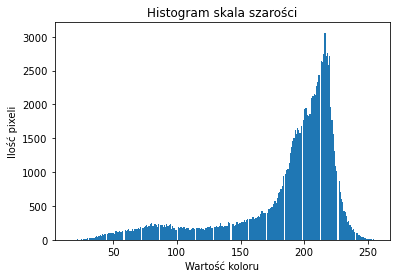

In [84]:
img_data = cv2.imread("./textures/bubbly.jpg", 0)
hist, _ = np.histogram(img_data, density=True, bins=256, range=(0, 256))
plt.hist(img_data.ravel(), bins=256)
plt.title("Histogram skala szarości")
plt.xlabel("Wartość koloru")
plt.ylabel("Ilość pixeli")  
plt.show()  

Zaś poniżej znajduje się kod który tę samą teskture wczytuje w skali RGB a następnie na podstawie tych danych tworzy histogram.

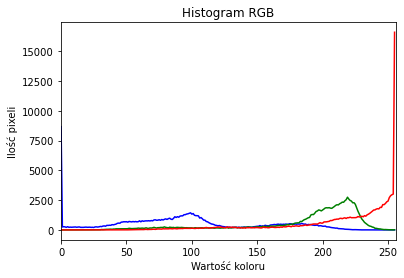

In [85]:
colors = ("blue", "green", "red")
img_data = cv2.imread("./textures/bubbly.jpg")

bgr_hist = []

plt.figure()
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        img_data[:, :, channel_id], bins=256, range=(0, 256)
    )
    bgr_hist.append(histogram)
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Histogram RGB")
plt.xlabel("Wartość koloru")
plt.ylabel("Ilość pixeli")  
plt.show()

### Ćwiczenie 5.1
1. Utworzyć histogram dla skali HSV dla tej samej tekstury, 
2. Utworzyć histogram 2D przy pomocy gotowej funkcji z biblioteki OpenCV dla tej samej tekstury.

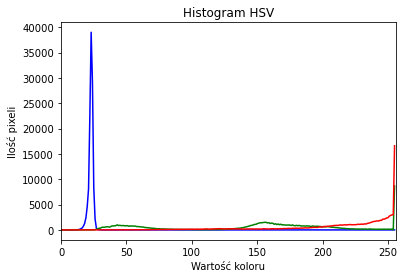

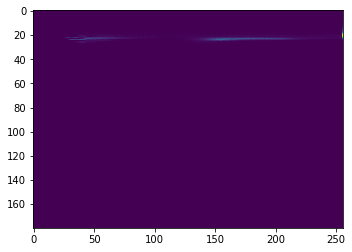

In [86]:
#Miejsce na rozwiązanie zadania
hsv_hist = []

img = cv2.imread("./textures/bubbly.jpg")
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

plt.figure()
plt.xlim([0, 256])
for channel_id, color in enumerate(colors):
    histogram, bin_edges = np.histogram(
        hsv_img[:, :, channel_id], bins=256, range=(0, 256)
    )
    hsv_hist.append(histogram)
    plt.plot(bin_edges[0:-1], histogram, color=color)

plt.title("Histogram HSV")
plt.xlabel("Wartość koloru")
plt.ylabel("Ilość pixeli")  
plt.show()

img = cv2.imread("./textures/bubbly.jpg")
hsv_img = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
hist = cv2.calcHist( [hsv_img], [0, 1], None, [180, 256], [0, 180, 0, 256] )
plt.imshow(hist, interpolation = 'nearest')
plt.show()

<a name="dominant_colors"></a>
## Dominant Color

W tej sekcji zostało opisane jak wydobyć dominujące kolory obrazu za pomocą Pythona. Klastrowanie jest używane w wielu rzeczywistych aplikacjach, jednym z takich praktycznych przykładów klastrowania jest właśnie wyodrębnianie dominujących kolorów z obrazu.

Każdy obraz składa się z pikseli, każdy piksel reprezentuje punkt w obrazie. Piksel zawiera trzy wartości, a każda wartość mieści się w zakresie od 0 do 255, reprezentując ilość składowych czerwonego, zielonego i niebieskiego. Połączenie tych form tworzy rzeczywisty kolor piksela. Aby znaleźć dominujące kolory, stosuje się koncepcję grupowania k-średnich. Jednym z ważnych zastosowań grupowania k-średnich jest np. segmentacja obrazów satelitarnych w celu identyfikacji cech powierzchni.

###Dominant color - przykład
Poniżej znajduje się funkcja za pomocą której można zwizualizować wektor cech dominujacych *n* kolorów w obrazie. 

In [87]:
def visualize_dominant_color(features_vector, file_name):
  block = np.ones((50, 50, 3),dtype='uint')
  plt.figure(figsize=(12, 8))
  for i in range(clusters):
      plt.subplot(1, clusters, i+1)
      block[:] = features_vector[i][1][::-1] # konwersja bgr to rgb
      plt.imshow(block)
      plt.xticks([])
      plt.yticks([])
      plt.xlabel(str(round(features_vector[i][0]*100, 2)) + '%')

  bar = np.ones((50, 500, 3),dtype='uint')
  plt.figure(figsize=(12, 8))
  plt.title('Proporcje kolorów w obrazie: ' + file_name)
  start = 0
  i = 1
  for p,c in features_vector:
      end = start + int(p*bar.shape[1])
      if i == clusters:
          bar[:,start:] = c[::-1]
      else:
          bar[:,start:end] = c[::-1]
      start = end
      i += 1
  plt.imshow(bar)
  plt.xticks([])
  plt.yticks([])
  plt.show()

Poniżej w funkcji został zamknięty proces wydobycia n dominujących kolorów ze spłaszczonego obrazu. 

Funkcja ta zwraca wektor cech z posortowaną wartością. Kolejne miejsca w tym wekotrze zawierają informacje o procentowej zawartości koloru w obrazie oraz jego wartości RGB. 

In [88]:
def get_features_vector(flat_img, clusters=5):
  kmeans = KMeans(n_clusters=clusters, random_state=0)
  kmeans.fit(flat_img)
  dominant_colors = np.array(kmeans.cluster_centers_, dtype='uint')
  percentages = (np.unique(kmeans.labels_, return_counts=True)[1])/flat_img.shape[0]
  features_vector = zip(percentages, dominant_colors)
  features_vector = sorted(features_vector, reverse=True)
  return features_vector

Funkcja ta wyrzuca niepotrzebne wartości procentowej wartości z wektora cech.

In [89]:
def convert_features_vector(features_vector):
  temp = []
  for color in features_vector:
    temp.append(color[1])
  return temp

Przykład wydobycia dominujących 5 kolorów z tekstury *'./textures/bubbly.jpg'*

Przed wypłaszczeniem -->  (348, 343, 3)
Po wypłaszczeniu -->  (119364, 3)


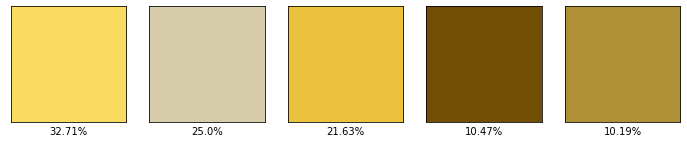

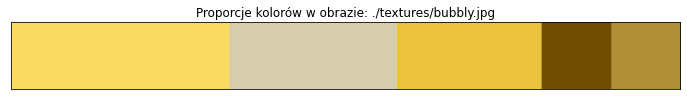

In [90]:
clusters = 5 
file_name = './textures/bubbly.jpg'
img = cv2.imread(file_name)

print('Przed wypłaszczeniem --> ',img.shape)
flat_img = np.reshape(img,(-1,3))
print('Po wypłaszczeniu --> ',flat_img.shape)

features_vector = get_features_vector(flat_img)
visualize_dominant_color(features_vector, file_name)

In [91]:
fv_to_analyse = convert_features_vector(features_vector)
print(fv_to_analyse)

[array([ 98, 218, 251], dtype=uint32), array([173, 205, 215], dtype=uint32), array([ 61, 194, 234], dtype=uint32), array([  5,  78, 114], dtype=uint32), array([ 54, 144, 176], dtype=uint32)]


### Ćwiczenie 6.1
1. Utworzyć wektory cech dla obrazków tekstur z rozszerzeniem ./texutures/typ.jpg, dla trzech ilości kolorów(5, 8, 16)
2. Utworzyć wektory cech z dominującymi kolorami  dla obrazków tesktur z rozszerzeniem ./texutures/typ_valid.jpg, dla trzech ilości kolorów(5, 8, 16)
3. Za pomocą powyższej funkcji *kullback_leibler_divergence* obliczyć odległość pomiędzy tymi samymi grupami tekstur ex. bubbly.jpg -> bubbly_valid.jpg,

**Pytania:**
1. Czy zwiększenie ilości kolorów powoduje zwiększenie się odległości obliczanej za pomocą funkcji *kullback_leibler_divergence*?
2. Czy wprowadzenie większej ilości kolorów pozytywnie wpłyneło na skuteczność ekstrakcji?
3.  Opisz etapy tworzenia deskryptora koloru dominującego. 

© copyright 2022: Daniel Mostowski, Politechnika Warszawska (Jupyter notebook adresowany dla studentów: ASO)